<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [140]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt
from scipy.stats import bernoulli, beta  
from bayes import *

import scipy.stats as stats
import statsmodels.stats.api as sms

In [95]:
# datos

df = pd.read_csv('data/cookie_cats.csv')

df.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


1. A/B Testing Bayes

In [96]:
# transformacion


# cambiar los datos de la columna 'retention_1' y retention_7' a 0 y 1

df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [97]:
df.groupby('version')['retention_1'].agg(['mean', 'count'])

,mean,count
version,,
gate_30,0.448188,44700
gate_40,0.442283,45489


In [98]:

df.groupby('version')['retention_7'].agg(['mean', 'count'])

,mean,count
version,,
gate_30,0.190201,44700
gate_40,0.182000,45489


In [99]:
# guardar las medias de gate_30 y gate_40 en variables para retencion 1

gate_30_mean_1 = df[df['version'] == 'gate_30']['retention_1'].mean()
gate_40_mean_1 = df[df['version'] == 'gate_40']['retention_1'].mean()

gate_30_mean_1, gate_40_mean_1

(0.4481879194630872, 0.44228274967574577)

In [100]:
# guardar las medias de gate_30 y gate_40 en variables para retencion 7

gate_30_mean_7 = df[df['version'] == 'gate_30']['retention_7'].mean()
gate_40_mean_7 = df[df['version'] == 'gate_40']['retention_7'].mean()

gate_30_mean_7, gate_40_mean_7

(0.19020134228187918, 0.18200004396667327)

In [101]:
df['retention_7'].value_counts(), df['retention_1'].value_counts()


(0    73408
 1    16781
 Name: retention_7, dtype: int64,
 0    50036
 1    40153
 Name: retention_1, dtype: int64)

In [102]:
# necesito saber los usuarios por version y por dia

df.groupby(['version', 'retention_1'])['userid'].count(), df.groupby(['version', 'retention_7'])['userid'].count()

(version  retention_1
 gate_30  0              24666
          1              20034
 gate_40  0              25370
          1              20119
 Name: userid, dtype: int64,
 version  retention_7
 gate_30  0              36198
          1               8502
 gate_40  0              37210
          1               8279
 Name: userid, dtype: int64)

In [103]:
# muestreo

# testeo para retention_1

# los datos son conocidos : impresiones y conversiones para test y control

imps_ctrl, convs_ctrl = 44700, 20034  

imps_test, convs_test = 45489, 20119


In [104]:
CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [105]:
a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test


beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [106]:
x=np.linspace(0.43, 0.48, 500)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

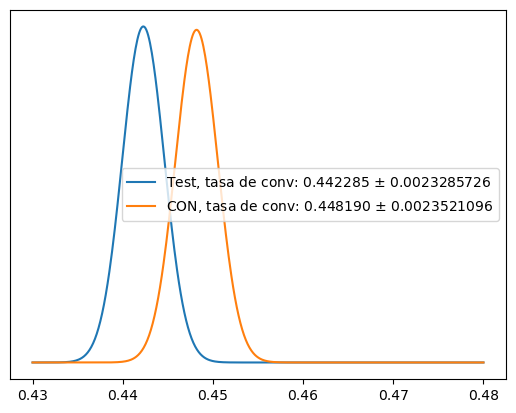

In [107]:
plot([beta_test, beta_control], ['Test', 'CON'])

In [108]:
calc_prob(beta_test, beta_control)

0.037206025180329845

In [109]:
salto = (beta_control.mean() - beta_test.mean())/beta_control.mean()

salto

0.013175098158249857

In [110]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un 1.32%, con una probabilidad del 0.79%'

In [111]:
# testeo para retention_7

# los datos son conocidos : impresiones y conversiones para test y control

imps_ctrl, convs_ctrl = 44700, 8502  

imps_test, convs_test = 45489, 8279 



In [112]:
CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [113]:
a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test


beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [114]:
x=np.linspace(0.18, 0.19, 500)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

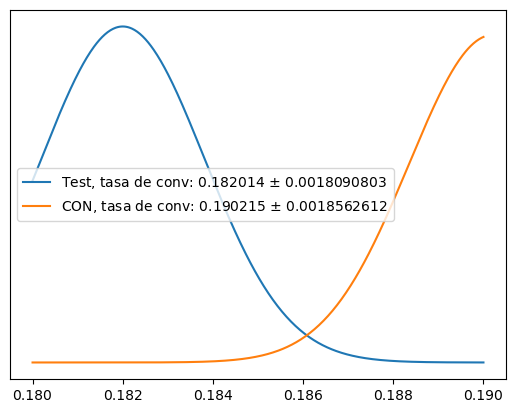

In [115]:
plot([beta_test, beta_control], ['Test', 'CON'])

In [116]:
calc_prob(beta_test, beta_control)

0.0007773386645759051

In [117]:
salto = (beta_control.mean() - beta_test.mean())/beta_control.mean()

salto

0.04311526114658881

In [118]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un 4.31%, con una probabilidad del 0.79%'

In [164]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

# retencion 1

# analizamos el retention 1, es decir, la retencion de los usuarios a los 1 dias de haber instalado el juego

# la tasa de conversion de los usuarios que instalaron el juego con la version gate_30 es de 44.82% y la de los usuarios que instalaron el juego con la version gate_40 es de 44.23%

# la diferencia entre las tasas de conversion es de 0.59%

# la probabilidad de que la version gate_30 sea mejor que la version gate_40 es de 96.00%   

# retencion 7

# analizamos el retention 7, es decir, la retencion de los usuarios a los 7 dias de haber instalado el juego

# la tasa de conversion de los usuarios que instalaron el juego con la version gate_30 es de 18.89% y la de los usuarios que instalaron el juego con la version gate_40 es de 18.20%

# la diferencia entre las tasas de conversion es de 0.69%

# la probabilidad de que la version gate_30 sea mejor que la version gate_40 es de 99.00%


2. A/B Testing

In [161]:
# retention 1
                           
impresiones = [44700, 45489]  

conversiones = [20034 , 20119]     

In [162]:
z_score, p_value = proportions_ztest(conversiones, nobs=impresiones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=impresiones,
                                                                alpha=0.05)

In [163]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 1.78
p-valor: 0.074
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.438, 0.447]


In [165]:
# retention 7
                           
impresiones = [44700, 45489]  

conversiones = [8502, 8279 ]   

In [166]:
z_score, p_value = proportions_ztest(conversiones, nobs=impresiones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=impresiones,
                                                                alpha=0.05)

In [167]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 3.16
p-valor: 0.002
intervalo conf 95% para grupo control: [0.187, 0.194]
intervalo conf 95% para grupo tratamiento: [0.178, 0.186]
